# Plot model fits for PEERS simulation analysis

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task

res_dir = Path(os.environ['PEERS_RESULTS'])
fit_dir = Path(os.environ['PEERS_FITS'])
fig_dir = Path(os.environ['PEERS_FIGURES']) / "sim1"

data_file = res_dir / 'peers_notask.csv'
patterns_file = res_dir / 'peers_patterns.hdf5'
figures.set_style()

/Users/morton/miniconda3/envs/cfr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/morton/miniconda3/envs/cfr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
models = [
    'cmrs_fcf-loc-use',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_rec_use1',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_enc_use1-B_rec_use1',
    'cmrs_fcf-loc_ff-use',
]
model_names = [
    'DCMR',
    'DCMR-Variable',
    'DCMR-Restricted',
    'DCMR-NoSemDrift',
    'CMR-MP16',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.3494320779585509, 0.6179457692495821, 0.5097488287111857),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.21624286340091695, 0.4448723771080803, 0.44657182426748937),
 (0.1705121585885322, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.6078198204764038, 0.8100431115060979, 0.6886397639333763),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.4070747349353, 0.652426424100314, 0.636598258552902),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.8450211160547234, 0.9362872108083329, 0.8814962450073144),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.7354447959037446, 0.8755917381696569, 0.8665505572807145),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [9]:
data['item_index'] = fr.pool_index(data['item'], patterns['items'])

In [10]:
drw = data.groupby('source').apply(
    fr.distance_rank_window, 
    'item_index', 
    1 - rsm, 
    np.array([-1, 0, 1]),
)

In [37]:
neg = drw.reset_index(0).query("lag == -1").set_index(["source", "subject"]).drop(columns="lag")
pos = drw.reset_index(0).query("lag == 1").set_index(["source", "subject"]).drop(columns="lag")
diff = pos - neg

LINO NOT subset; don't know how to subset; dropped


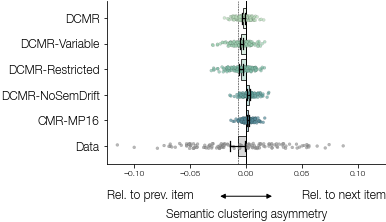

In [39]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    diff,
    x='rank',
    y='source',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='large')
ax.axvline(0, *ax.get_ylim(), linewidth=1, color='k')
ax.set(
    ylabel="", 
    xlabel="Semantic clustering asymmetry", 
    xlim=(-0.125, 0.125), 
)

# add annotation to help with interpretation
prop = dict(
    rotation='horizontal', 
    xycoords='axes fraction',
    verticalalignment='center',
    fontsize='large',
)
yoffset = -0.2
xoffset = 0.1
ax.annotate(
    'Rel. to prev. item', 
    xy=(0, yoffset), 
    horizontalalignment='left',
    **prop,
)
ax.annotate(
    'Rel. to next item', 
    xy=(1, yoffset), 
    horizontalalignment='right',
    **prop,
)
ax.annotate(
    '', 
    xy=(0.5 - xoffset, yoffset), 
    xytext=(0.5 + xoffset, yoffset), 
    arrowprops=dict(arrowstyle="<|-|>", facecolor='k'),
    xycoords='axes fraction',
)

ax.xaxis.set_label_coords(0.5, -0.28)
m = diff.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
None
fig.savefig(fig_dir / "dist_rank_asym.pdf")

In [15]:
lags = (
    drw.reset_index(level=1, drop=True)
    .set_index(["subject", "lag"], append=True)
    .unstack("lag").loc[:, "rank"]
)
diff = lags[-1] - lags[1]
p = diff.unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

,CMR-MP16,DCMR,DCMR-NoSemDrift,DCMR-Restricted,DCMR-Variable,Data
T,-3.072209,4.295555,-3.879039,4.859472,5.379066,2.100661
dof,125,125,125,125,125,125
alternative,two-sided,two-sided,two-sided,two-sided,two-sided,two-sided
p-val,0.002608,0.000035,0.000169,0.000003,0.0,0.03768
CI95%,"[-0.0, -0.0]","[0.0, 0.0]","[-0.0, -0.0]","[0.0, 0.01]","[0.0, 0.01]","[0.0, 0.01]"
cohen-d,0.273694,0.382678,0.345572,0.432916,0.479205,0.187142
BF10,8.513,453.722,104.082,3966.393,3.432e+04,0.827
power,0.861826,0.989343,0.970561,0.997894,0.999634,0.549583


## Serial position effects

In [16]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


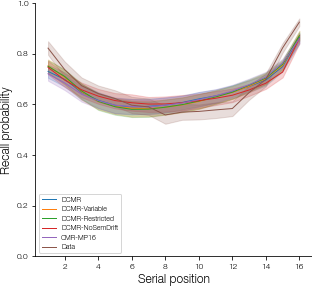

In [17]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.axes[0, 0].legend(fontsize='x-small')
g.savefig(fig_dir / 'spc_comp.pdf')

In [18]:
pnr = data.groupby('source').apply(fr.pnr)

LINO NOT subset; don't know how to subset; dropped


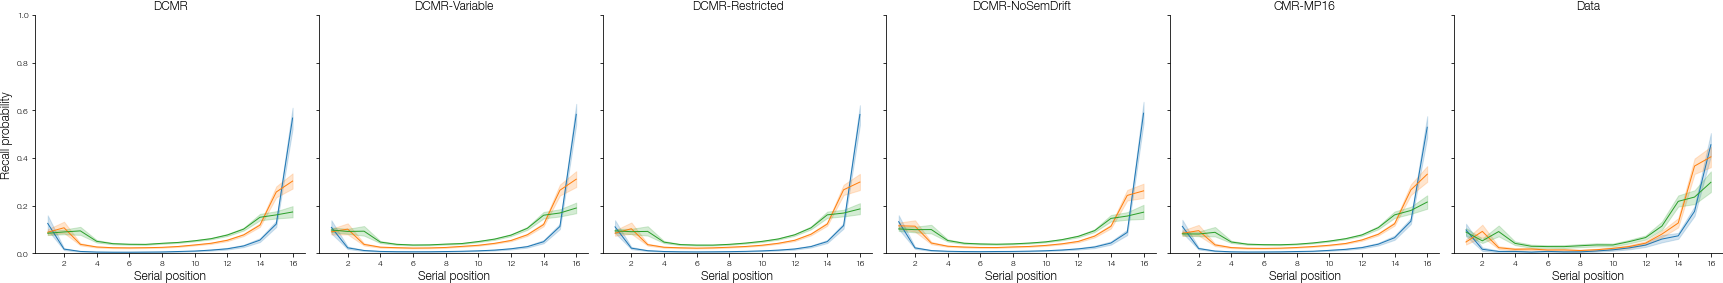

In [19]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='output', col='source', height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

## Clustering measures

In [20]:
lag_rank_within = data.groupby('source').apply(fr.lag_rank)

LINO NOT subset; don't know how to subset; dropped


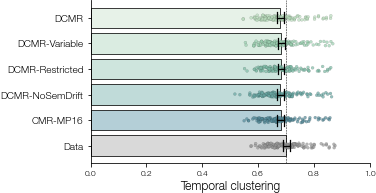

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [22]:
use_rank = data.groupby('source').apply(fr.distance_rank, 'item_index', 1 - rsm)

LINO NOT subset; don't know how to subset; dropped


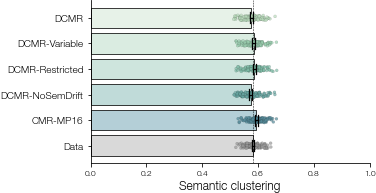

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    use_rank,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [24]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
)

LINO NOT subset; don't know how to subset; dropped


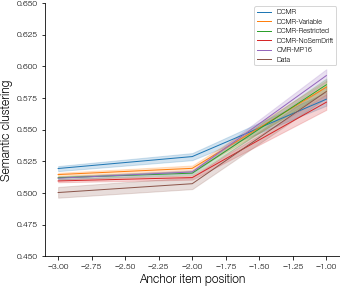

In [25]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [26]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.225321,250,two-sided,0.026952,"[0.0, 0.01]",0.280364,1.421,0.601349


In [27]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.521793,250,two-sided,8.395849e-08,"[0.01, 0.01]",0.695681,1.372e+05,0.9998


In [28]:
subs = dist_rank.loc['DCMR-Restricted']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.621362,250,two-sided,0.000355,"[0.0, 0.01]",0.456249,61.531,0.950267


## Compound lag-CRP

In [29]:
crp = data.groupby('source').apply(fr.lag_crp_compound)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

LINO NOT subset; don't know how to subset; dropped


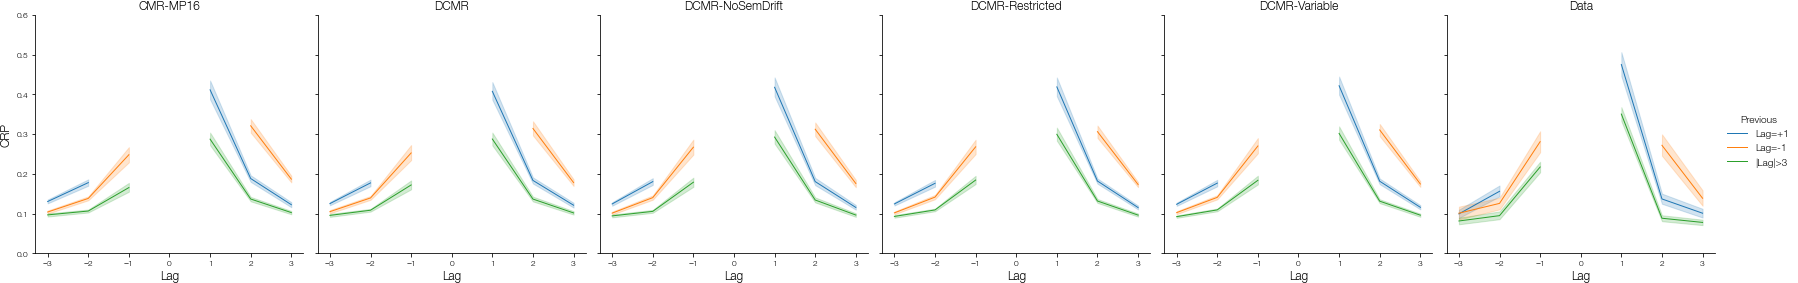

In [30]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [31]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.92118,125,two-sided,1.827842e-17,"[0.1, 0.15]",0.883849,3.079e+14,1.0


In [32]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.998669,125,two-sided,0.000002,"[0.04, 0.09]",0.445317,6970.418,0.99865


### Test for compound cuing in DCMR-Restricted

In [33]:
subs = summed.loc['DCMR-Restricted']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,23.331803,125,two-sided,2.235283e-47,"[0.11, 0.13]",2.078562,8.594e+43,1.0


In [34]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,17.494891,125,two-sided,2.104531e-35,"[0.07, 0.09]",1.558569,1.289e+32,1.0


In [35]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.13.0

mindstorm : 0.9.0
pingouin  : 0.5.2
matplotlib: 3.5.2
seaborn   : 0.11.1
cymr      : 0.11.2
psifr     : 0.9.0
numpy     : 1.20.2
cfr       : 0.1.0
pandas    : 1.2.3

